# Classification 

We have a classification Problem :


In [111]:
#Load the librarys
import pandas as pd #To work with dataset
import numpy as np #Math library
import seaborn as sns #Graph library that use matplot in background
import matplotlib.pyplot as plt #to plot some parameters in seaborn
import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
# Import StandardScaler from scikit-learn
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.ensemble import AdaBoostClassifier,VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from datetime import datetime, date
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as lgb
import tensorflow as tf 
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import sklearn.metrics as metrics
warnings.filterwarnings('ignore')

# Phase 1:Load Data 

In [112]:
# Read spreadsheet and assign it to swiss_loan
ml_dataset= pd.read_csv('../input/incomedata/ml_dataset.csv')

# Phase 2: Initial Preprocess and Clean Data

In [113]:
# code will replace the special character to nan and then drop the columns 
ml_dataset['native-country'] = ml_dataset['native-country'].replace('?',np.nan)
ml_dataset['worklass'] = ml_dataset['worklass'].replace('?',np.nan)
ml_dataset['occupation'] = ml_dataset['occupation'].replace('?',np.nan)#dropping the NaN rows now 
ml_dataset.dropna(how='any',inplace=True)

list_to_keep= ['age', 'worklass', 'fnlwgt', 'education', 'education-num',
       'martial-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income']
clean_reduced_df= ml_dataset[list_to_keep].copy()

clean_reduced_df.shape

(30162, 15)

# Phase3 :Transformation

In [114]:
clean_reduced_df['fnlwgt_log'] = np.log(clean_reduced_df['fnlwgt'])
clean_reduced_df['capital-gain_log'] = np.log(clean_reduced_df['capital-gain']+1)
clean_reduced_df['capital-loss _log'] = np.log(clean_reduced_df['capital-loss']+1)
clean_reduced_df.columns

Index(['age', 'worklass', 'fnlwgt', 'education', 'education-num',
       'martial-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income', 'fnlwgt_log', 'capital-gain_log', 'capital-loss _log'],
      dtype='object')

**I will not reduce Data : But if we have more time we will try to reduce demmension ...ex**

In [115]:
list_final= ['age', 'worklass',  'education', 'education-num',
       'martial-status', 'occupation', 'relationship', 'race', 'sex',
         'hours-per-week', 'native-country',
       'income', 'fnlwgt_log', 'capital-gain_log', 'capital-loss _log']
clean_reduced_final= clean_reduced_df[list_final].copy()

In [116]:
clean_reduced_final.shape 

(30162, 15)

# Classification Target 

In [117]:
clean_reduced_final["income"] = clean_reduced_final["income"].apply(lambda x:0 if 
                        x=='<=50K' else 1)
clean_reduced_final["income"].unique()

array([0, 1])

0    22654
1     7508
Name: income, dtype: int64


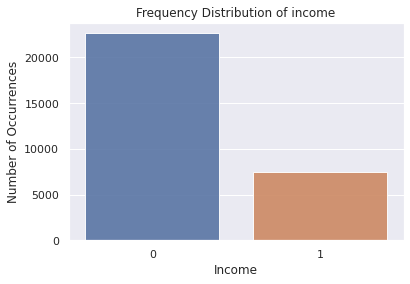

In [118]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt


# Get the counts of each category
Taux_counts = clean_reduced_final.income.value_counts()

# Print the count values for each category
print(Taux_counts)
sns.set(style="darkgrid")
sns.barplot(Taux_counts.index, Taux_counts.values, alpha=0.9)
plt.title('Frequency Distribution of income')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Income', fontsize=12)
plt.show()

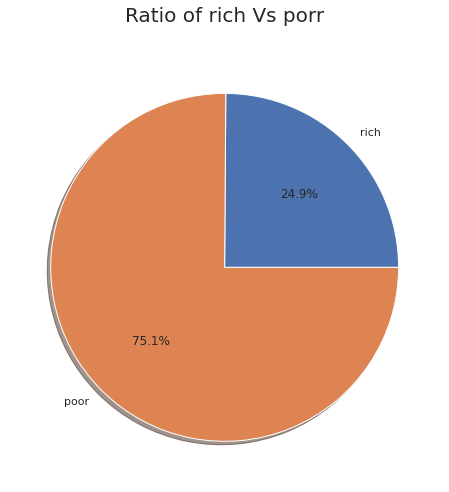

In [119]:
poor =len(clean_reduced_final[clean_reduced_final["income"]==0])
rich = len(clean_reduced_final[clean_reduced_final["income"]==1])

# Data to plot
labels = 'rich','poor'
sizes = [rich,poor]

# Plot
plt.figure(figsize=(10,8))
plt.pie(sizes, labels=labels,
autopct='%1.1f%%', shadow=True, startangle=0)
plt.title('Ratio of rich Vs porr\n', fontsize=20)
sns.set_context("paper", font_scale=2)



# X and y

In [120]:
# Create arrays for the features and the response variable
classification_cible = "income"
y = clean_reduced_final[classification_cible]
X = clean_reduced_final.drop(['income'], axis=1)

In [121]:
X.shape

(30162, 14)

In [122]:
y.shape

(30162,)

In [123]:
np.unique(y)

array([0, 1])

# Preprocess Pipe 
To combine the preprocessing steps specified in columntransformer with the model, we use a pipe externally. The following is its visual representation:
![image.png](attachment:image.png)
Columntransformer complements the pipeline well when we need to perform different operations on different subsets of columns.
https://developpaper.com/pipeline-columntransformer-and-featureunion/

In [124]:
from sklearn.pipeline import Pipeline, TransformerMixin
from sklearn.neighbors import LocalOutlierFactor

class OutlierReplace(BaseEstimator,TransformerMixin):
    def __init__(self,factor=1.5):
        self.factor = factor

    def outlier_removal(self,X,y=None):
        X = pd.Series(X).copy()
        qmin=X.quantile(0.05)
        qmax=X.quantile(0.95)
        q1 = X.quantile(0.25)
        q3 = X.quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - (self.factor * iqr)
        upper_bound = q3 + (self.factor * iqr)
        #X.loc[((X < lower_bound) | (X > upper_bound))] = np.nan 
        X.loc[X < lower_bound] = qmin
        X.loc[X > upper_bound] = qmax
        return pd.Series(X)

    def fit(self,X,y=None):
        return self

    def transform(self,X,y=None):
        return X.apply(self.outlier_removal)


In [125]:
np.random.seed(0)
# select the float columns
num_columns = X.select_dtypes(include=['int64','float64']).columns
# select non-numeric columns
cat_columns = X.select_dtypes(exclude=['int64','float64']).columns

fill_missing_then_one_hot_encoder = make_pipeline(
    SimpleImputer(strategy='most_frequent', fill_value='manquante',add_indicator=True),
    OneHotEncoder(handle_unknown='ignore')
)
fill_missing_then_Standar_scaler = make_pipeline( OutlierReplace(),
                                                 SimpleImputer(strategy='median',add_indicator=True),
    StandardScaler()
)

data_preprocess = make_column_transformer(
    ( fill_missing_then_one_hot_encoder , cat_columns),
    ( fill_missing_then_Standar_scaler, num_columns)
)
#X_pre =data_preprocess.fit_transform(X)
#y_pre= LabelEncoder().fit_transform(y.astype(str))
# Split the dataset and labels into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=clean_reduced_final[classification_cible])
print("{} rows in test set vs. {} in training set. {} Features.".format(X_test.shape[0], X_train.shape[0], X_test.shape[1]))

6033 rows in test set vs. 24129 in training set. 14 Features.


In [126]:
X_train.shape

(24129, 14)

# Phase - Find the Best Pipeline 
## Step 1 : Define CrossValidation Strategy :


In [62]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV



cross_validation_design = KFold(n_splits=5,
                                shuffle=True,
                                random_state=77)

cross_validation_design

KFold(n_splits=5, random_state=77, shuffle=True)

# Step 2 find the best model in iterative way 
## Pipeline 1 : RandomForest Classifer

In [63]:
from sklearn.ensemble import RandomForestClassifier as RandomForest

RF_MODEL = {}

# define pipe 
RF_MODEL['pipeline']=Pipeline([
                               ('data_cleaning', data_preprocess),
                               ('rf', RandomForest(random_state=7))])

# Define hyperparams
RF_MODEL['hyperparams'] = {}
RF_MODEL['hyperparams']['rf__n_estimators'] = [ 50, 100]
#RF_MODEL['hyperparams']['rf__max_features'] = [None, 'sqrt', 'log2', .1, .25, .50, .75, .85]
#RF_MODEL['hyperparams']['rf__max_depth'] = [None, 4, 7, 10, 20]

# Search d'HP
RF_MODEL['gridsearch'] = GridSearchCV(
    estimator=RF_MODEL['pipeline'],
    param_grid=RF_MODEL['hyperparams'],
    scoring='accuracy',
    cv=cross_validation_design
)

RF_MODEL['gridsearch'].fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=77, shuffle=True),
             estimator=Pipeline(steps=[('data_cleaning',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(add_indicator=True,
                                                                                                        fill_value='manquante',
                                                                                                        strategy='most_frequent')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                           

In [64]:
RF_MODEL['gridsearch'].best_params_

{'rf__n_estimators': 100}

{'rf__n_estimators': 100}

In [65]:
RF_MODEL['gridsearch'].best_score_

0.829499288182105

In [66]:
print("train roc_auc_scoree :{}".format(metrics.roc_auc_score(y_train,RF_MODEL['gridsearch'].predict_proba(X_train)[:,1])))
#print("test accucary score :{}".format(auc(grid_search,X_test, y_test)))
print("test roc_auc_score :{}".format(metrics.roc_auc_score(y_test,RF_MODEL['gridsearch'].predict_proba(X_test)[:,1])))

train roc_auc_scoree :0.9999987367558961
test roc_auc_score :0.8794280325416182


##  Pipe2 :XGB

In [67]:
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.feature_selection import SelectKBest, chi2
 # Deine the pipe :
XGB_pipe=Pipeline([('data_cleaning', data_preprocess),
                   ('XGB',  XGBClassifier(objective= 'binary:logistic', seed=42))])
#  Define our search space for grid search
search_space = [
  {
    'XGB__n_estimators': [50, 100],
    'XGB__learning_rate': [0.01, 0.3],
    #'XGB__max_depth': range(3, 10),
    #'XGB__colsample_bytree': [i/10.0 for i in range(1, 3)],
    #'XGB__gamma': [i/10.0 for i in range(3)],
    #'XGB__score_func': [chi2],
    #'XGB__k': [10],
  }
]
xgb_MODEL = GridSearchCV(estimator = XGB_pipe,param_grid = search_space, scoring='accuracy', cv=cross_validation_design)
xgb_MODEL.fit(X_train,y_train)

[23:38:51] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:38:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:38:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:38:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

GridSearchCV(cv=KFold(n_splits=5, random_state=77, shuffle=True),
             estimator=Pipeline(steps=[('data_cleaning',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(add_indicator=True,
                                                                                                        fill_value='manquante',
                                                                                                        strategy='most_frequent')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                           

In [68]:
 xgb_MODEL.best_params_, xgb_MODEL.best_score_                    

({'XGB__learning_rate': 0.3, 'XGB__n_estimators': 50}, 0.8432588333057767)

({'XGB__learning_rate': 0.3, 'XGB__n_estimators': 100},
 {'XGB__learning_rate': 0.3, 'XGB__n_estimators': 100},
 0.8454971065622523)

In [69]:
print("train roc_auc_scoree :{}".format(metrics.roc_auc_score(y_train,xgb_MODEL.predict_proba(X_train)[:,1])))
#print("test accucary score :{}".format(auc(grid_search,X_test, y_test)))
print("test roc_auc_score :{}".format(metrics.roc_auc_score(y_test,xgb_MODEL.predict_proba(X_test)[:,1])))

train roc_auc_scoree :0.9336570104654858
test roc_auc_score :0.8976647336399257


## Pipe 3 :LogisticRegression 


In [70]:
from sklearn.linear_model import LogisticRegression
LR_MODEL = {}

# define pipe 
LR_MODEL['pipeline']=Pipeline([
                               ('data_cleaning', data_preprocess),
                           ('LR', LogisticRegression())])

# Define hyperparams
LR_MODEL['hyperparams'] = {}
LR_MODEL['hyperparams']['LR__C'] = [0.1,1]
LR_MODEL['hyperparams']['LR__penalty'] = ['l2']
LR_MODEL['hyperparams']['LR__solver'] = ['newton-cg', 'liblinear']
# Search d'HP
LR_MODEL['gridsearch'] = GridSearchCV(
    estimator=LR_MODEL['pipeline'],
    param_grid=LR_MODEL['hyperparams'],
    scoring='accuracy',
    cv=cross_validation_design
)

LR_MODEL['gridsearch'].fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=77, shuffle=True),
             estimator=Pipeline(steps=[('data_cleaning',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(add_indicator=True,
                                                                                                        fill_value='manquante',
                                                                                                        strategy='most_frequent')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                           

In [71]:
 LR_MODEL['gridsearch'].best_params_, LR_MODEL['gridsearch'].best_score_   

({'LR__C': 1, 'LR__penalty': 'l2', 'LR__solver': 'liblinear'},
 0.840689391873466)

({'LR__C': 1, 'LR__penalty': 'l2', 'LR__solver': 'liblinear'},
 0.8408138472737268)

In [72]:
print("train roc_auc_scoree :{}".format(metrics.roc_auc_score(y_train,LR_MODEL['gridsearch'].predict_proba(X_train)[:,1])))
#print("test accucary score :{}".format(auc(grid_search,X_test, y_test)))
print("test roc_auc_score :{}".format(metrics.roc_auc_score(y_test,LR_MODEL['gridsearch'].predict_proba(X_test)[:,1])))

train roc_auc_scoree :0.8984197900354166
test roc_auc_score :0.8936354558227521


## pipe5:  GaussianNB

In [73]:
# Import Gaussian Naive Bayes model
from sklearn.naive_bayes import GaussianNB
class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()
GaussNB=Pipeline([('data_cleaning', data_preprocess),
                  ('to_dense', DenseTransformer()),
                  ('NB', GaussianNB())])
clf = GaussNB.fit(X_train, y_train)
clf.score(X_train, y_train)

0.5429566082307596

## pipe6 :  AdaBoostClassifier/RandomForestClassifier

In [74]:
from sklearn.metrics import  accuracy_score
accuracies={}
# Create a random forest classifier, fixing the seed to 2
Ada_model=Pipeline([('data_cleaning', data_preprocess),
                           ('NB', AdaBoostClassifier(random_state=2))])
Ada_model = Ada_model.fit(X_train, y_train)
# Use it to predict the labels of the test data
Ada_predictions = Ada_model.predict(X_test)
accuracies['Ada'] = accuracy_score(y_test, Ada_predictions)

# Create a random forest classifier, fixing the seed to 2
rf_model = RF_MODEL['pipeline'].fit(
  X_train, y_train)

# Use it to predict the labels of the test data
rf_predictions = rf_model.predict(X_test)

# Assess the accuracy of both classifiers
accuracies['rf'] = accuracy_score(y_test, rf_predictions)

In [75]:
for x, y in accuracies.items():
    print("model {} have an accuracy {}".format(x,y))

model Ada have an accuracy 0.8373943311785181
model rf have an accuracy 0.8274490303331675


## Pipe8 :Catboost

In [76]:
!pip install catboost

In [77]:
from catboost import CatBoostClassifier
#importing library and building model
modelcat=Pipeline([('data_cleaning', data_preprocess),
                  ('CAT', CatBoostClassifier(eval_metric="Accuracy", depth=10, iterations=15, l2_leaf_reg= 9, learning_rate= 0.15))])
modelcat.fit(X_train, y_train)

0:	learn: 0.8278835	total: 21.3ms	remaining: 299ms
1:	learn: 0.8288781	total: 33.9ms	remaining: 221ms
2:	learn: 0.8302458	total: 68.1ms	remaining: 273ms
3:	learn: 0.8334369	total: 85.7ms	remaining: 236ms
4:	learn: 0.8361308	total: 117ms	remaining: 235ms
5:	learn: 0.8373741	total: 149ms	remaining: 223ms
6:	learn: 0.8383688	total: 180ms	remaining: 206ms
7:	learn: 0.8396121	total: 212ms	remaining: 185ms
8:	learn: 0.8420573	total: 244ms	remaining: 163ms
9:	learn: 0.8427618	total: 276ms	remaining: 138ms
10:	learn: 0.8433006	total: 306ms	remaining: 111ms
11:	learn: 0.8442952	total: 338ms	remaining: 84.4ms
12:	learn: 0.8449583	total: 369ms	remaining: 56.8ms
13:	learn: 0.8465332	total: 400ms	remaining: 28.6ms
14:	learn: 0.8471963	total: 432ms	remaining: 0us


Pipeline(steps=[('data_cleaning',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 fill_value='manquante',
                                                                                 strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['worklass', 'education', 'martial-status', 'occupation', 'relationship',
       'race', 'sex', 'native-...
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('outlierreplac

In [78]:
print("train roc_auc_score :{}".format(metrics.roc_auc_score(y_train,modelcat.predict_proba(X_train)[:,1])))
#print("test accucary score :{}".format(auc(grid_search,X_test, y_test)))
print("test roc_auc_score :{}".format(metrics.roc_auc_score(y_test,modelcat.predict_proba(X_test)[:,1])))

train roc_auc_score :0.9083646861332675
test roc_auc_score :0.8962464819216988


# Pipe9 :KNN

In [79]:
from sklearn.neighbors import KNeighborsClassifier
# Define a grid for n_neighbors with values 10, 50 and 100
# define pipe 
KNN_pipe=Pipeline([
                               ('data_cleaning', data_preprocess),
                           ('KNN', KNeighborsClassifier())])
param_grid = {'KNN__n_neighbors': [5,50]}

# Optimize for KNeighborsClassifier() using GridSearchCV
gridknn = GridSearchCV(KNN_pipe, param_grid,scoring='accuracy', cv=cross_validation_design)
gridknn.fit(X_train, y_train)
gridknn.best_params_

{'KNN__n_neighbors': 50}

{'KNN__n_neighbors': 50}

In [80]:
print("train roc_auc_score :{}".format(metrics.roc_auc_score(y_train,gridknn.predict_proba(X_train)[:,1])))
#print("test accucary score :{}".format(auc(grid_search,X_test, y_test)))
print("test roc_auc_score :{}".format(metrics.roc_auc_score(y_test,gridknn.predict_proba(X_test)[:,1])))

train roc_auc_score :0.9028873883202637
test roc_auc_score :0.8887410033146419


# Try Ensemble Models :
##  Stacking :
###  Stacking model1 :EnsembleVoteClassifier

In [81]:
print(X_train.shape, X_test.shape)

(24129, 14) (6033, 14)


In [82]:
# Prepare x :
X_train_pre =data_preprocess.fit_transform(X_train)
X_test_pre =data_preprocess.fit_transform(X_test)

### Explain Stacking :

[23:54:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


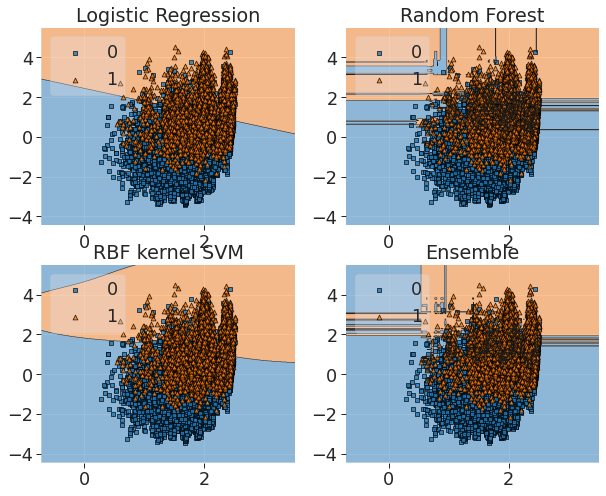

In [88]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import EnsembleVoteClassifier
from mlxtend.data import iris_data
from mlxtend.plotting import plot_decision_regions
from sklearn.decomposition import PCA,TruncatedSVD
# Initializing Classifiers
clf1 = LogisticRegression(random_state=0,solver='liblinear')
clf2 = RandomForestClassifier(random_state=0)
clf3 = SVC(random_state=0, probability=True)
clf4= XGBClassifier()
eclf = EnsembleVoteClassifier(clfs=[clf1, clf2, clf3,clf4],
                              weights=[1, 2, 1,2], voting='soft')
pca = TruncatedSVD(n_components=2)
X_reduced=pca.fit_transform(X_train_pre)
# Plotting Decision Regions

gs = gridspec.GridSpec(2, 2)
fig = plt.figure(figsize=(10, 8))

labels = ['Logistic Regression',
          'Random Forest',
          'RBF kernel SVM',
          'Ensemble']

for clf, lab, grd in zip([clf1, clf2, clf3,clf4, eclf],
                         labels,
                         itertools.product([0, 1],
                         repeat=2)):
    clf.fit(X_reduced, y_train)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X_reduced, y=y_train.to_numpy(),
                                clf=clf, legend=2)
    plt.title(lab)

plt.show()

In [89]:
eclf.fit(X_train_pre, y_train)

[23:56:34] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


EnsembleVoteClassifier(clfs=[LogisticRegression(random_state=0,
                                                solver='liblinear'),
                             RandomForestClassifier(random_state=0),
                             SVC(probability=True, random_state=0),
                             XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           gpu_id=-1, importance_type='gain',
                                           interaction_constraints='',
                                           learning_rate=0.300000012,
                                           max_delta_step=0, max_depth=6,
                                           min_child_weight=1, missing=nan,
                                           monotone_constraints='()',
               

In [90]:
print("train roc_auc_score:{}".format(metrics.roc_auc_score(y_train,eclf.predict_proba(X_train_pre)[:,1])))

train roc_auc_score:0.9823360485088676



### Model stack3 - Using Probabilities as Meta-Features

Alternatively, the class-probabilities of the first-level classifiers can be used to train the meta-classifier (2nd-level classifier) by setting use_probas=True. If average_probas=True, the probabilities of the level-1 classifiers are averaged, if average_probas=False, the probabilities are stacked (recommended). For example, in a 3-class setting with 2 level-1 classifiers, these classifiers may make the following "probability" predictions for 1 training sample:

    classifier 1: [0.2, 0.5, 0.3]
    classifier 2: [0.3, 0.4, 0.4]

If average_probas=True, the meta-features would be:

        [0.25, 0.45, 0.35]

In contrast, using average_probas=False results in k features where, k = [n_classes * n_classifiers], by stacking these level-1 probabilities:

        [0.2, 0.5, 0.3, 0.3, 0.4, 0.4]



In [91]:
from mlxtend.classifier import StackingClassifier
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression(solver='liblinear')
sclf_with_proba = StackingClassifier(classifiers=[clf1, clf2, clf3],
                          use_probas=True,
                          meta_classifier=lr)
sclf_with_proba.fit(DenseTransformer().fit_transform(X_train_pre), y_train)


StackingClassifier(classifiers=[LogisticRegression(random_state=0,
                                                   solver='liblinear'),
                                RandomForestClassifier(random_state=0),
                                SVC(probability=True, random_state=0)],
                   meta_classifier=LogisticRegression(solver='liblinear'),
                   use_probas=True)

In [92]:
print("train roc_auc_score :{}".format(metrics.roc_auc_score(y_train,sclf_with_proba.predict_proba(DenseTransformer().fit_transform(X_train_pre))[:,1])))

train roc_auc_score :0.9999997381639493


## Stack 3

In [93]:
from mlxtend.classifier import StackingClassifier
stack3= StackingClassifier(
    classifiers=[
        LogisticRegression(solver='liblinear'),
        XGBClassifier()
    ],
    use_probas=True,
    meta_classifier=LogisticRegression()
)
stack3.fit(X_train_pre, y_train)


[00:02:18] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


StackingClassifier(classifiers=[LogisticRegression(solver='liblinear'),
                                XGBClassifier(base_score=None, booster=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None, gamma=None,
                                              gpu_id=None,
                                              importance_type='gain',
                                              interaction_constraints=None,
                                              learning_rate=None,
                                              max_delta_step=None,
                                              max_depth=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                              

In [94]:
print("train roc_auc_score :{}".format(metrics.roc_auc_score(y_train,stack3.predict_proba(X_train_pre)[:,1])))


train roc_auc_score :0.9582610688801716


# Select the best Pipeline 
## Evaluation Metric : AUC 
I will just keep simple models 

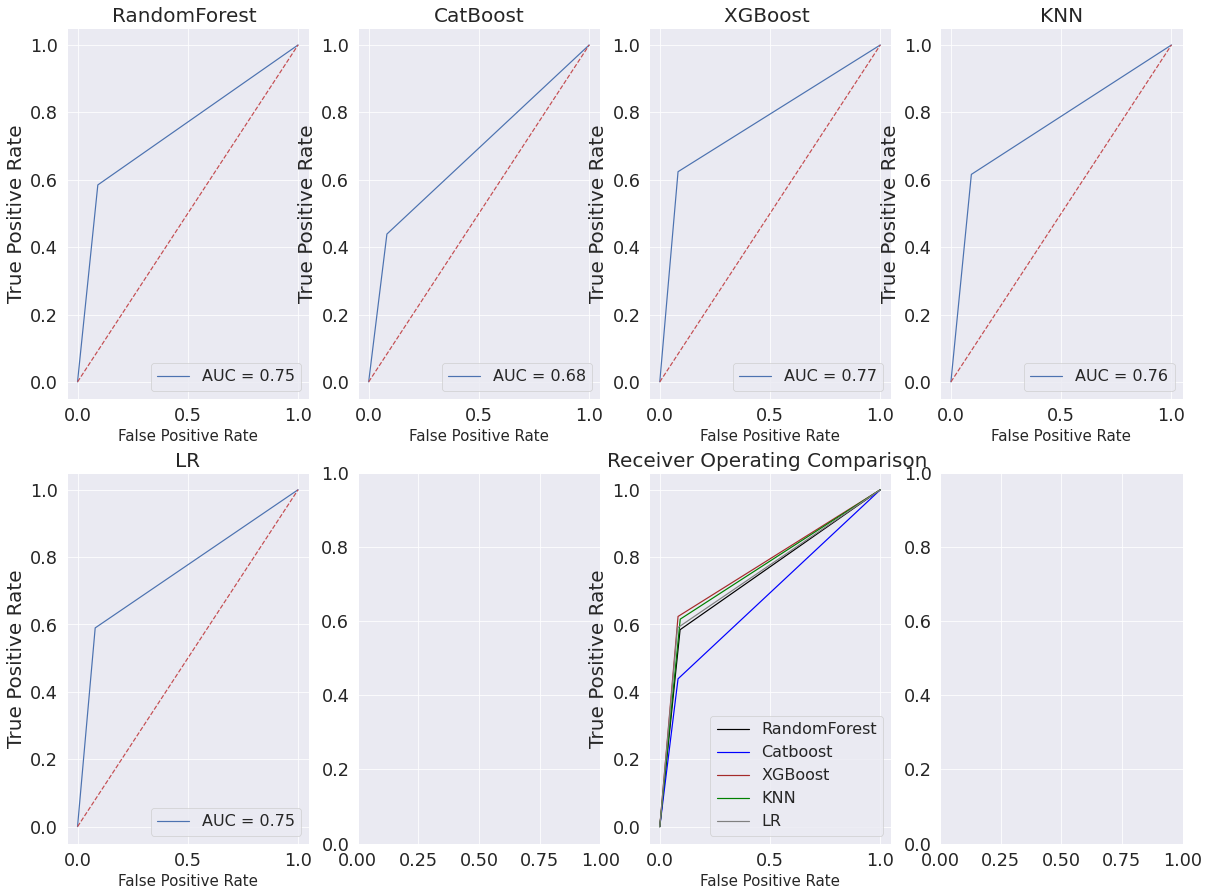

In [95]:
fig, ax_arr = plt.subplots(nrows = 2, ncols = 4, figsize = (20,15))


#----------RandomForest---------


RadomForest_pred = RF_MODEL['gridsearch'].predict(X_test)
fprdm, tprdm, thresholddm = metrics.roc_curve(y_test,RadomForest_pred)
roc_aucrf = metrics.auc(fprdm,tprdm)

ax_arr[0,0].plot(fprdm,  tprdm, 'b', label = 'AUC = %0.2f' % roc_aucrf)
ax_arr[0,0].plot([0, 1], [0, 1],'r--')
ax_arr[0,0].set_title('RandomForest ',fontsize=20)
ax_arr[0,0].set_ylabel('True Positive Rate',fontsize=20)
ax_arr[0,0].set_xlabel('False Positive Rate',fontsize=15)
ax_arr[0,0].legend(loc = 'lower right', prop={'size': 16})


#----------Catboost---------

modelcat_pred = modelcat.predict(X_test)
fprlog, tprlog, thresholdlog = metrics.roc_curve(y_test, modelcat_pred)
roc_auccat = metrics.auc(fprlog, tprlog)

ax_arr[0,1].plot(fprlog, tprlog, 'b', label = 'AUC = %0.2f' % roc_auccat)
ax_arr[0,1].plot([0, 1], [0, 1],'r--')
ax_arr[0,1].set_title('CatBoost',fontsize=20)
ax_arr[0,1].set_ylabel('True Positive Rate',fontsize=20)
ax_arr[0,1].set_xlabel('False Positive Rate',fontsize=15)
ax_arr[0,1].legend(loc = 'lower right', prop={'size': 16})


#----------XGBoost---------


XGBClassifier_pred = xgb_MODEL.predict(X_test)
#preds = probs[:,1]
fprsm, tprsm, thresholdsm = metrics.roc_curve(y_test, XGBClassifier_pred)
roc_aucxgb = metrics.auc(fprsm, tprsm)


ax_arr[0,2].plot(fprsm, tprsm, 'b', label = 'AUC = %0.2f' % roc_aucxgb)
ax_arr[0,2].plot([0, 1], [0, 1],'r--')
ax_arr[0,2].set_title('XGBoost ',fontsize=20)
ax_arr[0,2].set_ylabel('True Positive Rate',fontsize=20)
ax_arr[0,2].set_xlabel('False Positive Rate',fontsize=15)
ax_arr[0,2].legend(loc = 'lower right', prop={'size': 16})



#----------KNN---------

Knn_pred = gridknn.predict(X_test)
#preds = probs[:,1]
fprgnb, tprgnb, thresholdgnd = metrics.roc_curve(y_test, Knn_pred)
roc_aucxgb = metrics.auc(fprgnb, tprgnb)


ax_arr[0,3].plot(fprgnb, tprgnb, 'b', label = 'AUC = %0.2f' % roc_aucxgb)
ax_arr[0,3].plot([0, 1], [0, 1],'r--')
ax_arr[0,3].set_title('KNN',fontsize=20)
ax_arr[0,3].set_ylabel('True Positive Rate',fontsize=20)
ax_arr[0,3].set_xlabel('False Positive Rate',fontsize=15)
ax_arr[0,3].legend(loc = 'lower right', prop={'size': 16})


#----------LinearRegression_MODEL---------


LR_MODEL_pred = LR_MODEL['gridsearch'].predict(X_test)
#preds = probs[:,1]
fprfst, tprfst, thresholdfst = metrics.roc_curve(y_test, LR_MODEL_pred)
roc_aucLR= metrics.auc(fprfst, tprfst)


ax_arr[1,0].plot(fprfst, tprfst, 'b', label = 'AUC = %0.2f' % roc_aucLR)
ax_arr[1,0].plot([0, 1], [0, 1],'r--')
ax_arr[1,0].set_title('LR',fontsize=20)
ax_arr[1,0].set_ylabel('True Positive Rate',fontsize=20)
ax_arr[1,0].set_xlabel('False Positive Rate',fontsize=15)
ax_arr[1,0].legend(loc = 'lower right', prop={'size': 16})




#----------ALL---------


ax_arr[1,2].plot(fprdm, tprdm, 'b', label = 'RandomForest', color='black')
ax_arr[1,2].plot(fprlog, tprlog, 'b', label = 'Catboost', color='blue')
ax_arr[1,2].plot(fprsm, tprsm, 'b', label = 'XGBoost', color='brown')
ax_arr[1,2].plot(fprgnb, tprgnb, 'b', label = 'KNN', color='green')
ax_arr[1,2].plot(fprfst, tprfst, 'b', label = 'LR', color='grey')
ax_arr[1,2].set_title('Receiver Operating Comparison ',fontsize=20)
ax_arr[1,2].set_ylabel('True Positive Rate',fontsize=20)
ax_arr[1,2].set_xlabel('False Positive Rate',fontsize=15)
ax_arr[1,2].legend(loc = 'lower right', prop={'size': 16})

**AS we see i find that rondom forest really perfom well .
It will be slected**
# Final Phase : train our model in all data wihout CV, evaluate it again and save it  

In [127]:
model_final = Pipeline([('data_cleaning', data_preprocess),
                        ('rf', RandomForest(random_state=7, n_estimators=100))
                        ])


# fit on all data
model_final.fit(X, y)

Pipeline(steps=[('data_cleaning',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 fill_value='manquante',
                                                                                 strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['worklass', 'education', 'martial-status', 'occupation', 'relationship',
       'race', 'sex', 'native-...
      dtype='object')),
                                                 ('pipeline-2',
                                                  Pipelin

## Complet Evaluation

In [128]:
#  Import necessary modules
from  sklearn.metrics import classification_report,confusion_matrix
# predict 
# Predict the labels of the test data: y_pred
y_pred = model_final.predict(X)

# Generate the confusion matrix and classification report
print(confusion_matrix(y, y_pred))
print(classification_report(y, y_pred))

[[22648     6]
 [    7  7501]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22654
           1       1.00      1.00      1.00      7508

    accuracy                           1.00     30162
   macro avg       1.00      1.00      1.00     30162
weighted avg       1.00      1.00      1.00     30162



So Good results , but keep in mind the real estimation of the model is done via our CV strategy .

    Real test accuracy : 0.8307431894165671
    Real test roc_auc_score :0.8766168760199378 
**Can we do better and enhance the result??!!**   


# Data Centric Approch 
## Balance the dataset with synthetic samples (SMOTE)
In addition to being extremely small, our training dataset has the unbalanced target  variable, which can undermine some models' predictability. We will perform an oversampling, which consists of creating new samples to increase the 0 minority class. For this we will use the SMOTE technique.

SMOTE (Synthetic Minority Oversampling TEchnique) consists of synthesizing elements for the minority class, based on those that already exist. It works randomly picingk a point from the minority class and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point and its neighbor



In [129]:
# select the float columns
num_columns = X.select_dtypes(include=['int64','float64']).columns
# select non-numeric columns
cat_columns = X.select_dtypes(exclude=['int64','float64']).columns

fill_missing_then_one_hot_encoder = make_pipeline(
    SimpleImputer(strategy='most_frequent', fill_value='manquante'),
    OneHotEncoder(handle_unknown='ignore')
)
fill_missing_then_Standar_scaler = make_pipeline(SimpleImputer(strategy='median'),
    StandardScaler()
)

data_preprocess = make_column_transformer(
    ( fill_missing_then_one_hot_encoder , cat_columns),
    ( fill_missing_then_Standar_scaler, num_columns)
)

# Prepare Data again 

In [130]:
X_pre =data_preprocess.fit_transform(X)

# Split the dataset and labels into training and test sets
X_train, X_test, y_train, y_test = X_train, X_test, y_train, y_test = train_test_split(X_pre, y, test_size=0.2, stratify=y)
print("{} rows in test set vs. {} in training set. {} Features.".format(X_test.shape[0], X_train.shape[0], X_test.shape[1]))

6033 rows in test set vs. 24129 in training set. 104 Features.


In [131]:
X_train.shape


(24129, 104)

In [132]:
X_test.shape

(6033, 104)

we will add data only for training , test data will kept untouched 

<AxesSubplot:title={'center':'Count (target)'}>

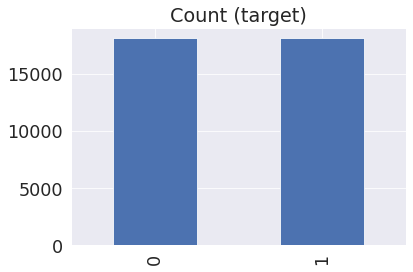

In [133]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='auto')
X_sm, y_sm = smote.fit_resample(X_train, y_train)

df = pd.DataFrame(X_sm)
df['target'] = y_sm

df['target'].value_counts().plot(kind='bar', title='Count (target)')

In [134]:
X_sm.shape

(36246, 104)

In [135]:
y_sm.shape

(36246,)

# Train our best Model from previous steps :

In [136]:
from sklearn.ensemble import RandomForestClassifier as RandomForest

RF_MODEL = {}

# define pipe 
RF_MODEL['pipeline']=Pipeline([('rf', RandomForest(random_state=7))])

# Define hyperparams
RF_MODEL['hyperparams'] = {}
RF_MODEL['hyperparams']['rf__n_estimators'] = [  100,200]
#RF_MODEL['hyperparams']['rf__max_features'] = [None, 'sqrt', 'log2', .1, .25, .50, .75, .85]
#RF_MODEL['hyperparams']['rf__max_depth'] = [None, 4, 7, 10, 20]

# Search d'HP
RF_MODEL['gridsearch'] = GridSearchCV(
    estimator=RF_MODEL['pipeline'],
    param_grid=RF_MODEL['hyperparams'],
    scoring='accuracy',
    cv=cross_validation_design
)

RF_MODEL['gridsearch'].fit(X_sm, y_sm)

GridSearchCV(cv=KFold(n_splits=5, random_state=77, shuffle=True),
             estimator=Pipeline(steps=[('rf',
                                        RandomForestClassifier(random_state=7))]),
             param_grid={'rf__n_estimators': [100, 200]}, scoring='accuracy')

In [137]:
RF_MODEL['gridsearch'].best_params_

{'rf__n_estimators': 200}

# Final Evaluation 

In [138]:
RF_MODEL['gridsearch'].best_score_

0.8983061140418893

In [139]:
def plot_roc_auc(y_test, y_score, classes):
    assert len(classes) >= 1, "len classes must be >= 1"
    plt.figure()
    if len(classes) > 2:  # multi-label
        # Compute ROC curve and ROC area for each class
        for i in range(len(classes)):
            fpr, tpr, _ = metrics.roc_curve(y_test[:, i], y_score[:, i])
            roc_auc = metrics.auc(fpr, tpr)
            plt.plot(fpr, tpr, label='ROC curve of class {0} (area = {1:0.2f})'.format(classes[i], roc_auc))
        # Compute micro-average ROC curve and ROC area
        fpr, tpr, _ = roc_curve(y_test.ravel(), y_score.ravel())
        roc_auc = auc(fpr, tpr)
        # Plot ROC curve
        plt.plot(fpr, tpr, label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc))
    else:
        fpr, tpr, _ = metrics.roc_curve(y_test, y_score)
        roc_auc = metrics.auc(fpr, tpr)
        plt.plot(fpr, tpr, label='ROC curve (area = {0:0.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [140]:
print("train roc_auc_scoree :{}".format(metrics.roc_auc_score(y_sm,RF_MODEL['gridsearch'].predict_proba(X_sm)[:,1])))
#print("test accucary score :{}".format(auc(grid_search,X_test, y_test)))
print("test roc_auc_score :{}".format(metrics.roc_auc_score(y_test,RF_MODEL['gridsearch'].predict_proba(X_test)[:,1])))

train roc_auc_scoree :1.0
test roc_auc_score :0.9053829059231256


In [141]:
# Predict the labels of the test data: y_pred
y_pred = RF_MODEL['gridsearch'].predict(X_test)

# Generate the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[4039  492]
 [ 423 1079]]
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      4531
           1       0.69      0.72      0.70      1502

    accuracy                           0.85      6033
   macro avg       0.80      0.80      0.80      6033
weighted avg       0.85      0.85      0.85      6033



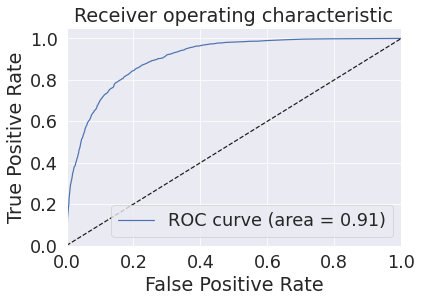

In [142]:
classes=['incoome']
y_pred=RF_MODEL['gridsearch'].predict_proba(X_test)[:,1]
plot_roc_auc(y_test, y_pred,classes)

In [143]:
RF_MODEL['gridsearch'].score(X_test, y_test)

0.8483341621084037

==> As we see  have a better acccuracy just but adding more data 

# Deep learning Approch :
## Prepare Data :


In [144]:
## Deep Learning Approch :
y1 = y_sm
X1 = DenseTransformer().fit_transform(X_sm)
# Print the dimensions of X and y 
print("Dimensions of y : {}".format(y1.shape))
print("Dimensions of X : {}".format(X1.shape))

Dimensions of y : (36246,)
Dimensions of X : (36246, 104)


# Define/Compile the model

In [145]:
import tensorflow as tf
from tensorflow.keras import regularizers
tf.random.set_seed(128)
print(tf.test.gpu_device_name())

/device:GPU:0


In [146]:
# First define baseline model. Then use it in Keras Classifier for the training
def Classification_model():
    # Create model here
    model =tf.keras.Sequential()
    model.add(layers.Dense(15, input_dim = 104, activation = 'relu')) # Rectified Linear Unit Activation Function
    model.add(layers.Dense(15, activation = 'relu'))
    model.add(layers.Dense(1, activation = 'sigmoid')) # Softmax for multi-class classification
    # Compile model here
    optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    return model
Classification_Model = Classification_model()
Classification_Model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 15)                1575      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                240       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 16        
Total params: 1,831
Trainable params: 1,831
Non-trainable params: 0
_________________________________________________________________


In [147]:
EPOCHS =1000
# configure early stopping
es = EarlyStopping(monitor='val_loss',min_delta=0.0000000000001, patience=10)
#batch_size=1000
# fit model using our gpu
with tf.device('/gpu:0'):
     history1 = Classification_Model.fit(X1,y1,batch_size=128,epochs=EPOCHS, validation_split = 0.1, verbose=0 ,callbacks=[es])

In [148]:
Classification_Model.save('Classification_Model.h5') 

## Plot History1

In [149]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training accuracy')
    plt.plot(x, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

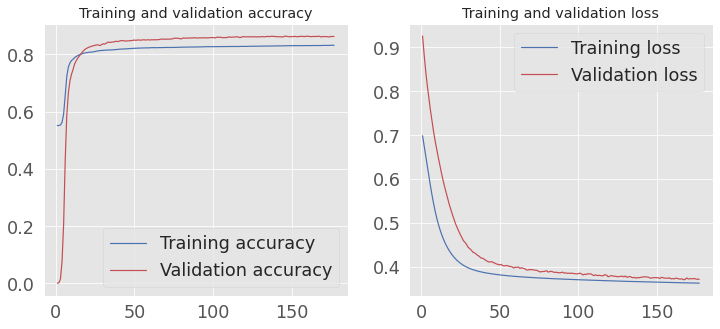

In [150]:
 plot_history(history1)

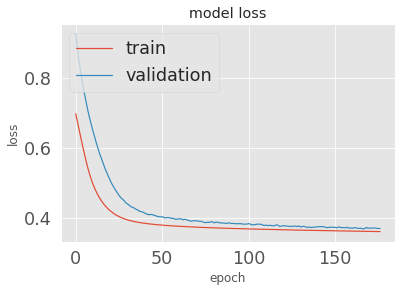

In [151]:
#Let’s see what this looks like when we plot our respective losses:
# "Loss"
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [152]:
# evaluate the keras model

loss, accuracy = Classification_Model.evaluate( X1, y1, verbose=2)
print(" Accuracy".format(accuracy))

1133/1133 - 1s - loss: 0.3629 - accuracy: 0.8342
 Accuracy


# More deep :Regularization in Deep Learning — L1, L2,BatchNormalization, and Dropout

In [153]:
inputs= tf.keras.layers.Input(shape=(104,1), name='input_vector')
X = tf.keras.layers.LSTM(128)(inputs)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Dense(128, activation='relu',
                          kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
    bias_regularizer=regularizers.l2(1e-4),)(X)
X = tf.keras.layers.Dropout(0.2)(X)
y = tf.keras.layers.Dense(1,activation = 'sigmoid' ,name='outputs')(X)

# define input and output layers of our model
model = tf.keras.Model(inputs=[inputs], outputs=y)

In [154]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_vector (InputLayer)    [(None, 104, 1)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
outputs (Dense)              (None, 1)                 129       
Total params: 83,713
Trainable params: 83,457
Non-trainable params: 256
_______________________________________________________

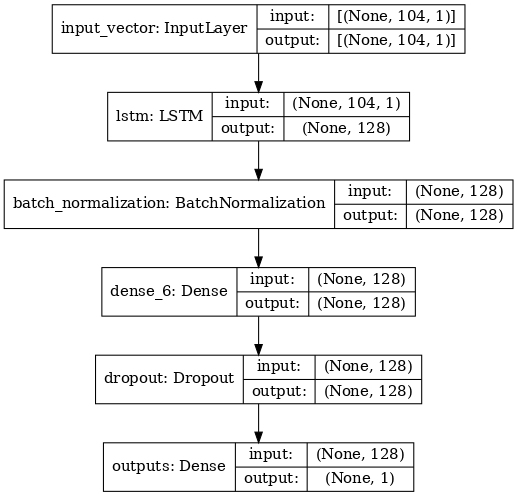

In [155]:
tf.keras.utils.plot_model(model=model, show_shapes=True, dpi=76, )

In [156]:
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
optimizer = tf.keras.optimizers.Adam(0.01)
#loss = tf.keras.losses.CategoricalCrossentropy()  # categorical = one-hot

best_weights_file = "./weights.h5"
batch_size = 128
max_epochs= 1000
#m_ckpt = ModelCheckpoint(best_weights_file, monitor='val_accuracy', mode='max', verbose=2,
                            # save_weights_only=True, save_best_only=True)
es = EarlyStopping(monitor='val_loss',min_delta=0.0000000000000000001, patience=10)
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])


## Training our Deep learning
We can now train our model. First, we configure our optimizer (Adam), our loss function, and our precision metric. Then we compile the model and practice!


In [157]:
# fit model using our gpu
with tf.device('/gpu:0'):
    history = model.fit(X1,y1,batch_size=128,epochs=EPOCHS, validation_split = 0.1, verbose=0 ,callbacks=[es])

## Evaluate Model 

In [158]:
loss, accuracy = model.evaluate( X1, y1, verbose=2)


1133/1133 - 4s - loss: 10.1516 - accuracy: 0.5016


In [159]:
print('accuracy: %f' % (accuracy *100))
print('loss_model: %f' % (loss *100))

accuracy: 50.162774
loss_model: 1015.162945


## Plot History

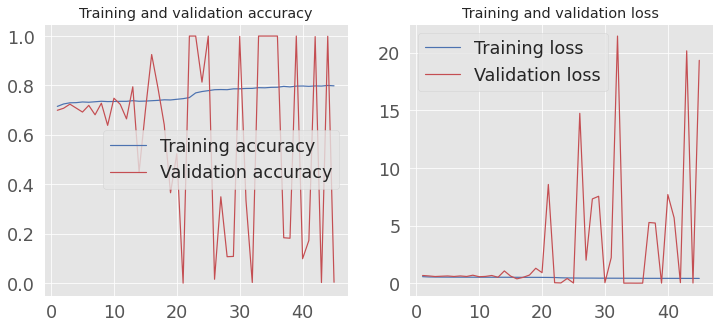

In [160]:

plot_history(history)

**this new architecture is overfitting becasue we have a complex model and small data**

# Deploy your solution 
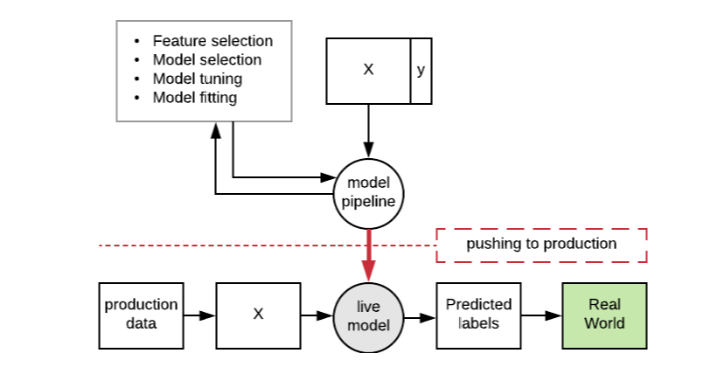



Finally, it is time for you to push your first model to production. It is a random forest classifier which you will use as a baseline, while you are still working to develop a better alternative. You have access to the data split in training test with their usual names, X_train, X_test, y_train and y_test, as well as to the modules RandomForestClassifier() and pickle, whose methods .load() and .dump() you will need for this exercise.

In [161]:
# Fit a random forest to the training set
clf = RandomForestClassifier(random_state=42).fit(
  X_train, y_train)

# Save it to a file, to be pushed to production
with open('model.pkl', 'wb') as file:
    pickle.dump(clf, file=file)

# Now load the model from file in the production environment
with open('model.pkl', 'rb') as file:
    clf_from_file = pickle.load(file)

# Predict the labels of the test dataset
preds = clf_from_file.predict(X_test)

NameError: name 'pickle' is not defined